데이터 출처 : https://www.kaggle.com/datasets/kingabzpro/movie-reviews-nlp

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
df = pd.read_csv('moviereviews.tsv', sep='\t')
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   object
 1   review  1965 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [4]:
# 결측치 제거
df = df.dropna()

In [5]:
# 중복데이터 확인 및 제거
df.review.nunique()

1939

In [6]:
df.drop_duplicates(subset=['review'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1939 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1939 non-null   object
 1   review  1939 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [7]:
# 레이블(긍정, 부정) 비율 확인
df.label.value_counts(normalize=True)

neg    0.500258
pos    0.499742
Name: label, dtype: float64

In [8]:
# 정규표현식 사용하여 텍스트 전처리 -> 소문자로 통일, 알파벳, 공백 외에 모두 제거
import re

for idx, text in enumerate(df['review']):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-z0-9 ]', '', text)
    df['review'][idx] = text

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [10]:
X = df['review']
Y = df['label']

le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [11]:
# 데이터셋 분리
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=df['label'], random_state=42)

In [12]:
print(f'훈련세트 리뷰의 평균 문장 길이: {np.mean([len(sent) for sent in X_train], dtype=int)}')
print(f'훈련세트 리뷰의 최대 문장 길이: {max(len(sent) for sent in X_train)}')

훈련세트 리뷰의 평균 문장 길이: 3762
훈련세트 리뷰의 최대 문장 길이: 14522


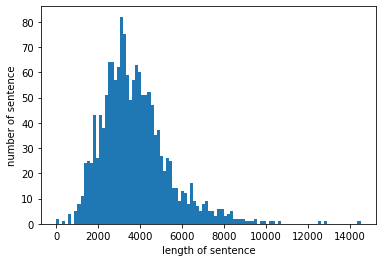

In [15]:
plt.hist([len(sent) for sent in X_train], bins=100)
plt.xlabel('length of sentence')
plt.ylabel('number of sentence')
plt.show()

In [16]:
max_words = 3000
max_len = 6000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [20]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words, 150, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
#     layer = Dense(256,name='FC1')(layer)
#     layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [21]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 6000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 6000, 150)         450000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                55040     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 out_layer (Dense)           (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 505,105
Trainable params: 505,105
Non-trainab

In [22]:
model.fit(sequences_matrix, Y_train, batch_size=128, epochs=10,
         validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)])

Epoch 1/10
10/10 [==============================] - 2256s 231s/step - loss: 0.6941 - accuracy: 0.4863 - val_loss: 0.6948 - val_accuracy: 0.4437
Epoch 2/10
10/10 [==============================] - 2788s 284s/step - loss: 0.6860 - accuracy: 0.6161 - val_loss: 0.6956 - val_accuracy: 0.4759
Epoch 3/10
10/10 [==============================] - 3239s 329s/step - loss: 0.7225 - accuracy: 0.6863 - val_loss: 0.6918 - val_accuracy: 0.5305
Epoch 4/10
10/10 [==============================] - 3146s 316s/step - loss: 0.6020 - accuracy: 0.7718 - val_loss: 0.7068 - val_accuracy: 0.5273
Epoch 5/10
10/10 [==============================] - 3286s 330s/step - loss: 0.5147 - accuracy: 0.7992 - val_loss: 0.7353 - val_accuracy: 0.5241
Epoch 6/10
10/10 [==============================] - 3395s 340s/step - loss: 0.4107 - accuracy: 0.8492 - val_loss: 0.8325 - val_accuracy: 0.5498


In [25]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

# 모델 일반화성능 검증
accr = model.evaluate(test_sequences_matrix, Y_test)

13/13 [==============================] - 9s 685ms/step - loss: 0.8602 - accuracy: 0.5077


In [26]:
print('Loss:', round(accr[0], 3), '\n Accuracy:', round(accr[1], 3))

Loss: 0.86 
 Accuracy: 0.508
